In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None, 'display.max_rows', 100) 

from os import path
import pickle

import sys
sys.path.append('..')
import src.functions.my_functions as my_func

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics.scorer import make_scorer

from sklearn.metrics import f1_score, recall_score, precision_score, fbeta_score

from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import SelectFromModel, SelectKBest, SelectPercentile, RFECV, f_classif

from sklearn.decomposition import PCA

In [2]:
from imp import reload
reload(my_func)

<module 'src.functions.my_functions' from '..\\src\\functions\\my_functions.py'>

### Import Data

In [4]:
data = {}

ds = ['train', 'train_target', 'test', 'test_target']
d = ['..', 'data', 'processed']

for s in ds:    
    fn = 'loan_'+s+'.p'
    fp = path.join(*d, fn)

    with open(fp, 'rb') as file:
        data[s] = pickle.load(file)

In [5]:
data['train'].shape, data['train_target'].shape

((152218, 47), (152218, 2))

In [6]:
data['test'].shape, data['test_target'].shape

((38055, 47), (38055, 2))

### Data Prep

In [7]:
# Columns identified thus far as best for classification (during data prep, select K best)
num_attr = ['funded_amnt_q10', 'int_rate_delta', 'annual_inc_q10', 'dti', 'delinq_2yrs', 'inq_last_6mths',
            'open_acc', 'revol_bal_log', 'revol_util', 'total_acc', 'collections_12_mths_ex_med',
            'acc_now_delinq', 'rev_lim_sqrt', 'tot_cur_bal', 'tot_coll_amt', 'subgrade_p_value',
            'lti', 'rbti', 'tbti', 'cr_line_td_log', 'emp_length_val']

bin_attr = ['had_delinq', 'had_major_derog', 'had_record', 'verified', 'term_bin']

cat_attr = ['purpose', 'home_ownership']

In [8]:
num_prep = Pipeline([('custom', my_func.CustomNumAttributes()), # Create custom num attr
                     ('select', my_func.DataFrame_Selector(num_attr)), # Select num columns
                     ('sc', StandardScaler())]) # Scale data

bin_prep = Pipeline([('custom', my_func.CustomBinAttributes()), # Create custom bin attr
                     ('select', my_func.DataFrame_Selector(bin_attr))]) # Select binary columns

cat_prep = Pipeline([('encode', my_func.DataFrame_DummyEncoder(cat_attr))]) # Select & encode categrocial columns

feature_prep = FeatureUnion([('num', num_prep),
                             ('bin', bin_prep),
                             ('cat', cat_prep)])

In [9]:
X_train_full = feature_prep.fit_transform(data['train'])
X_test = feature_prep.transform(data['test'])

y_train_full = data['train_target']['default']
y_test = data['test_target']['default']

In [10]:
def get_feature_prep_columns(feature_union):
    num_cols = feature_union.transformer_list[0][1].named_steps['select'].get_feature_names()
    bin_cols = feature_union.transformer_list[1][1].named_steps['select'].get_feature_names()
    cat_cols = feature_union.transformer_list[2][1].named_steps['encode'].get_feature_names()
    cols = num_cols + bin_cols + cat_cols
    return cols

In [11]:
feature_names = get_feature_prep_columns(feature_prep)
len(feature_names)

44

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [13]:
f2_score = make_scorer(fbeta_score, beta=2)

### OneR Baseline

In [14]:
oner = DecisionTreeClassifier(class_weight='balanced', max_depth=1)
oner.fit(X_train, y_train);

In [23]:
oner_cvs = cross_val_score(oner, X_train, y_train, cv=5, scoring=f2_score)
my_func.print_cvs(oner_cvs, 'f2')

Mean f2 score = 0.525 (+\- 0.010)


In [17]:
my_func.classifier_summary(y_train, oner.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               58462               39852
Actual Positive                7996               15464
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.518383
Recall           0.659165
Precision (pos)  0.279557
Precision (neg)  0.879683
Specificity      0.594646


In [19]:
my_func.classifier_summary(y_val, oner.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               14564               10066
Actual Positive                2017                3797
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.511463
Recall           0.653079
Precision (pos)  0.273895
Precision (neg)  0.878355
Specificity      0.591311


### Parameter Tuning

In [30]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision'}

param_grid = {'max_depth': np.arange(1,41,1)}
              
dtc_depth_gs = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'),
                              param_grid = param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4)

my_func.run_time(reset=True)
dtc_depth_gs.fit(X_train, y_train)
my_func.run_time()

Time: 1min 16s 


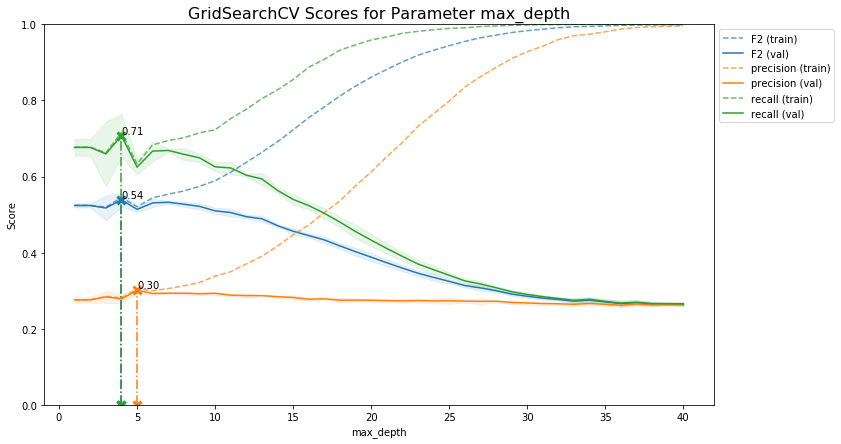

In [31]:
my_func.plot_gs_param(dtc_depth_gs, figsize=(12,7))

In [37]:
np.concatenate((np.arange(2,10,1),
                np.arange(10,100,10),
                np.arange(100,1000,100),
                np.arange(1000,10001,1000)))

array([    2,     3,     4,     5,     6,     7,     8,     9,    10,
          20,    30,    40,    50,    60,    70,    80,    90,   100,
         200,   300,   400,   500,   600,   700,   800,   900,  1000,
        2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000, 10000])

In [42]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision'}

param_grid = {'min_samples_split': np.concatenate((np.arange(2,10,1),
                                    np.arange(10,100,10),
                                    np.arange(100,1000,100),
                                    np.arange(1000,10001,1000)))}
              
dtc_mss_gs = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=20),
                              param_grid = param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4)

my_func.run_time(reset=True)
dtc_mss_gs.fit(X_train, y_train)
my_func.run_time()

Time: 1min 1s 


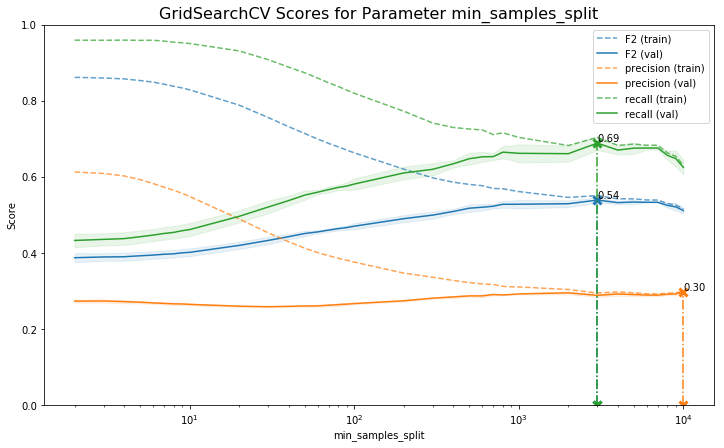

In [43]:
my_func.plot_gs_param(dtc_mss_gs, set_xscale='log', figsize=(12,7))

In [46]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision'}

param_grid = {'min_samples_leaf': np.concatenate((np.arange(2,10,1),
                                    np.arange(10,100,10),
                                    np.arange(100,1000,100),
                                    np.arange(1000,10001,1000)))}
              
dtc_msl_gs = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=20),
                              param_grid = param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4)

my_func.run_time(reset=True)
dtc_msl_gs.fit(X_train, y_train)
my_func.run_time()

Time: 46.34s 


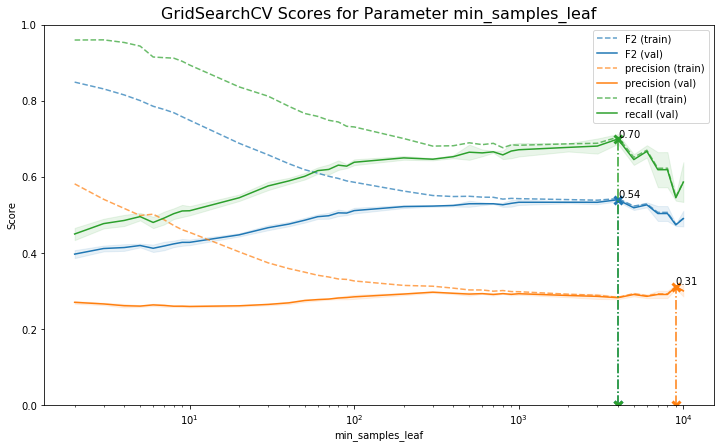

In [47]:
my_func.plot_gs_param(dtc_msl_gs, set_xscale='log', figsize=(12,7))

In [48]:
np.concatenate((np.array(['sqrt', 'log2', None]), np.arange(0.1,1.0,0.1)))

array(['sqrt', 'log2', None, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
       0.7000000000000001, 0.8, 0.9], dtype=object)

In [55]:
np.concatenate((np.array([None]), np.arange(0.1,1.0,0.1)))

array([None, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
       0.7000000000000001, 0.8, 0.9], dtype=object)

In [62]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

mss = np.concatenate((np.arange(10,100,1), np.arange(100,1000,10), np.arange(1000,5001,100)))
msl = mss
md = np.concatenate((np.arange(1,10,1), np.arange(10,31,5)))
mf = np.concatenate((np.arange(0.1,1.0,0.05), np.array([None, 'sqrt', 'log2'])))

param_grid = {'min_samples_split': mss,
              'min_samples_leaf': msl,
              'max_depth': md,
              'max_features': mf,
              'criterion': ['gini', 'entropy']}
              
dtc_rs = RandomizedSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'),
                              param_distributions = param_grid,
                              scoring=scoring,
                              cv=3,
                              n_iter=1000,
                              refit=False,
                              n_jobs=4,
                              verbose=3)

my_func.run_time(reset=True)
dtc_rs.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   10.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   28.5s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 1560 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done 2040 tasks      | elapsed:  7.3min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  9.3min


Time: 10min 47s 


[Parallel(n_jobs=4)]: Done 3000 out of 3000 | elapsed: 10.8min finished


In [63]:
my_func.gs_score_summary(dtc_rs)

--------------------
Best F2:
Params: {'min_samples_split': 95, 'min_samples_leaf': 230, 'max_features': 0.6500000000000001, 'max_depth': 2, 'criterion': 'entropy'}
F2 = 0.5475770807242489
Recall = 0.7647912476077755
Precision = 0.2572664358052903
Specificity = 0.47118421463043647
--------------------
Best Recall:
Params: {'min_samples_split': 4000, 'min_samples_leaf': 1800, 'max_features': 0.40000000000000013, 'max_depth': 1, 'criterion': 'entropy'}
F2 = 0.5074311433624381
Recall = 0.8297502465365277
Precision = 0.21288677619726654
Specificity = 0.23807320038659793
--------------------
Best Precision:
Params: {'min_samples_split': 900, 'min_samples_leaf': 490, 'max_features': 0.9000000000000002, 'max_depth': 3, 'criterion': 'gini'}
F2 = 0.4779484373982533
Recall = 0.5589939984417068
Precision = 0.3029256008506247
Specificity = 0.6928819825918605
--------------------
Best Specificity:
Params: {'min_samples_split': 560, 'min_samples_leaf': 570, 'max_features': 'log2', 'max_depth': 1, 'c

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
RandomForestClassifier?